# Next Character Prediction
_Student 902011, Moleri Andrea, a.moleri@campus.unimib.it_

The task is next character prediction in a text. Starting from the provided skeleton of the code:

- properly divide the sequences into training, validation and test. Eventually use an external text for the test to assess the generalization ability
- evaluate the trained model in terms of prediction accuracy
- tune the chunk length to obtain the best performance
- modify the network architecture to obtain the best performance

In aggiunta:

Comunque vuole sia il notebook che la stampa in PDF del notebook 

### Inspecting the Data

Opening file...
Text Length: 558240

****** First 1000 characters ******

inferno



inferno: canto i


nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.

ahi quanto a dir qual era e` cosa dura
  esta selva selvaggia e aspra e forte
  che nel pensier rinova la paura!

tant'e` amara che poco e` piu` morte;
  ma per trattar del ben ch'i' vi trovai,
  diro` de l'altre cose ch'i' v'ho scorte.

io non so ben ridir com'i' v'intrai,
  tant'era pien di sonno a quel punto
  che la verace via abbandonai.

ma poi ch'i' fui al pie` d'un colle giunto,
  la` dove terminava quella valle
  che m'avea di paura il cor compunto,

guardai in alto, e vidi le sue spalle
  vestite gia` de' raggi del pianeta
  che mena dritto altrui per ogne calle.

allor fu la paura un poco queta
  che nel lago del cor m'era durata
  la notte ch'i' passai con tanta pieta.

e come quei che con lena affannata
  uscito fuor del pelago a la riva
  si volge a l'acqua perigl

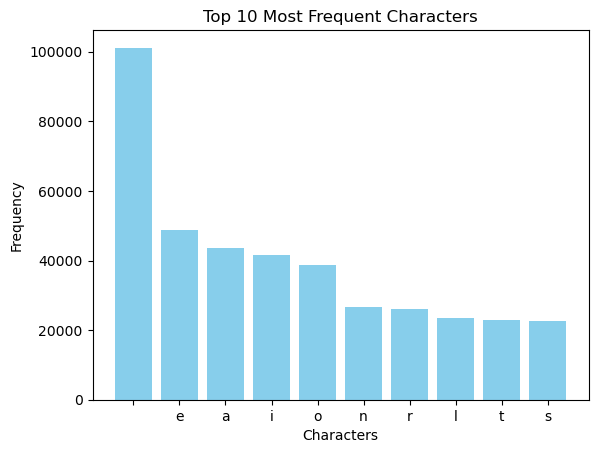

In [48]:
import io
import numpy as np
import random
import requests

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

print('Opening file...')

# Define the URL of the "Divina Commedia" text file 
path = 'https://raw.githubusercontent.com/andreamoleri/AML-Assignments/refs/heads/main/Assignment%204/divina_commedia.txt'

# Fetch the content of the text file from the specified URL
response = requests.get(path)
response.raise_for_status()  # Ensure that the request was successful
text = response.text.lower()  # Convert the text to lowercase for uniformity

# Display the length of the text and the first 1000 characters for inspection
print('Text Length:', len(text))
print('\n****** First 1000 characters ******\n')
print(text[:1000])

# Create a sorted list of unique characters present in the text
chars = sorted(list(set(text)))
print('total chars: ', len(chars))

# Create mappings from characters to indices and vice versa
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# Display the character-to-index and index-to-character mappings
print(char_indices)
print(indices_char)

# Define the maximum length of each sequence and the step size for creating sequences
maxlen = 30 
step = 3

# Initialize lists to store the sequences and their corresponding next characters
sentences = []
next_chars = []

# Generate overlapping sequences of length `maxlen` and their corresponding next characters
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])

# Display the number of sequences created and examples of sequences and next characters
print('number of sequences: ', len(sentences))
print(sentences[11])
print(next_chars[11])

# Calculate the frequency of each character in the text
from collections import Counter
char_counts = Counter(text)

# Sort the characters by their frequency in descending order
sorted_counts = sorted(char_counts.items(), key=lambda x: x[1], reverse=True)

# Display the top 10 most frequent characters and their frequencies
print('\nTop 10 most frequent characters:')
for char, count in sorted_counts[:10]:
    print(f"'{char}': {count} occurrences")

# Plot a bar chart of the top 10 most frequent characters
import matplotlib.pyplot as plt
char_labels, char_freqs = zip(*sorted_counts[:10])
plt.bar(char_labels, char_freqs, color='skyblue')
plt.title('Top 10 Most Frequent Characters')
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.show()

### Preparing the Data

In [49]:
# Inform the user that the preprocessing of sequences for training, validation, and testing is starting.
print('Preparing sequences for training, validation, and testing...')

# Define the maximum sequence length to be used for training.
maxlen = 30  

# Obtain the unique characters in the text and sort them to ensure consistent encoding.
chars = sorted(set(text))
# Map each unique character to a unique integer index.
char_indices = {char: i for i, char in enumerate(chars)}
# Map each integer index back to its corresponding character.
indices_char = {i: char for char, i in char_indices.items()}
# Display the total number of unique characters.
print(f"Total characters: {len(chars)}")

# Initialize lists to store input sequences and their corresponding target characters.
sentences = []
next_chars = []

# Generate sequences of length `maxlen` with their respective next characters as targets.
# Loop with a stride of 3 to avoid overly similar sequences.
for i in range(0, len(text) - maxlen, 3): 
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])

# Display the total number of sequences generated for training.
print(f"Number of sequences generated: {len(sentences)}")

# Initialize the input (x) and output (y) arrays for training with boolean values.
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)

# One-hot encode the sequences and their respective next characters.
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1  # One-hot encode the input sequence characters.
    y[i, char_indices[next_chars[i]]] = 1  # One-hot encode the target characters.

# Display the shapes of the input and output arrays to verify their structure.
print('Input (x) and Output (y) shapes:')
print(x.shape)
print(y.shape)

# Define the proportions of data to be used for training, validation, and testing splits.
train_split = 0.8
val_split = 0.1  

# Calculate the sizes of the training and validation sets based on the total number of sequences.
train_size = int(len(sentences) * train_split)
val_size = int(len(sentences) * val_split)

# Split the data into training, validation, and test sets.
x_train, y_train = x[:train_size], y[:train_size]
x_val, y_val = x[train_size:train_size + val_size], y[train_size:train_size + val_size]
x_test, y_test = x[train_size + val_size:], y[train_size + val_size:]

# Display the size of each data split to ensure proper partitioning.
print('\nData split:')
print(f'Training set: {x_train.shape}, {y_train.shape}')
print(f'Validation set: {x_val.shape}, {y_val.shape}')
print(f'Test set: {x_test.shape}, {y_test.shape}')

Preparing sequences for training, validation, and testing...
Total characters: 40
Number of sequences generated: 186070
Input (x) and Output (y) shapes:
(186070, 30, 40)
(186070, 40)

Data split:
Training set: (148856, 30, 40), (148856, 40)
Validation set: (18607, 30, 40), (18607, 40)
Test set: (18607, 30, 40), (18607, 40)


In [50]:
## Building the Models

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Model 1: Baseline model
print("Building Model 1...")
chunk_length_1 = 30  # Baseline chunk length
x_train_1 = x_train[:, :chunk_length_1, :]  # Adjust training data
x_val_1 = x_val[:, :chunk_length_1, :]
x_test_1 = x_test[:, :chunk_length_1, :]

model_1 = Sequential()
model_1.add(LSTM(128, input_shape=(chunk_length_1, len(chars))))  # Single LSTM layer
model_1.add(Dense(len(chars), activation='softmax'))  # Output layer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model_1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_1.summary()

# Model 2: Improved model with increased chunk length and layers
print("\nBuilding Model 2...")
chunk_length_2 = 40  # Increased chunk length
x_train_2 = x_train[:, :chunk_length_2, :]  # Adjust training data
x_val_2 = x_val[:, :chunk_length_2, :]
x_test_2 = x_test[:, :chunk_length_2, :]

model_2 = Sequential()
model_2.add(LSTM(256, input_shape=(chunk_length_2, len(chars)), return_sequences=True))  # Stacked LSTM
model_2.add(Dropout(0.2))  # Regularization
model_2.add(LSTM(128))  # Second LSTM layer
model_2.add(Dense(len(chars), activation='softmax'))  # Output layer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005)  # Reduced learning rate for stability
model_2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_2.summary()

# Model 3: Advanced model with further increased chunk length
print("\nBuilding Model 3...")
chunk_length_3 = 50  # Further increased chunk length
x_train_3 = x_train[:, :chunk_length_3, :]  # Adjust training data
x_val_3 = x_val[:, :chunk_length_3, :]
x_test_3 = x_test[:, :chunk_length_3, :]

model_2 = Sequential()
model_2.add(LSTM(256, input_shape=(chunk_length_2, len(chars)), return_sequences=True))  # Stacked LSTM
model_2.add(Dropout(0.3))  # Regularization
model_2.add(LSTM(128))  # Second LSTM layer
model_2.add(Dense(len(chars), activation='softmax'))  # Output layer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005)  # Reduced learning rate for stability
model_2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_2.summary()

Building Model 1...
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 128)               86528     
                                                                 
 dense_16 (Dense)            (None, 40)                5160      
                                                                 
Total params: 91688 (358.16 KB)
Trainable params: 91688 (358.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Building Model 2...
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 40, 256)           304128    
                                                                 
 dropout_13 (Dropout)        (None, 40, 256)           0         
                 

Evaluating Model 1...
Training Model 1...
Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 2.7074 - accuracy: 0.2261
******* Epoch: 1 ********
***** Starting sentence *****
men caro,
  se oltre promessio
*****************************
***** Generated text *****
men caro,
  se oltre promessio di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di 

73/73 [==============================] - 75s 1s/step - loss: 2.7074 - accuracy: 0.2261 - val_loss: 2.2037 - val_accuracy: 0.3208
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 2.1131 - accuracy: 0.3414
******* Epoch: 2 ********
***** Starting sentence *****
eare e ne

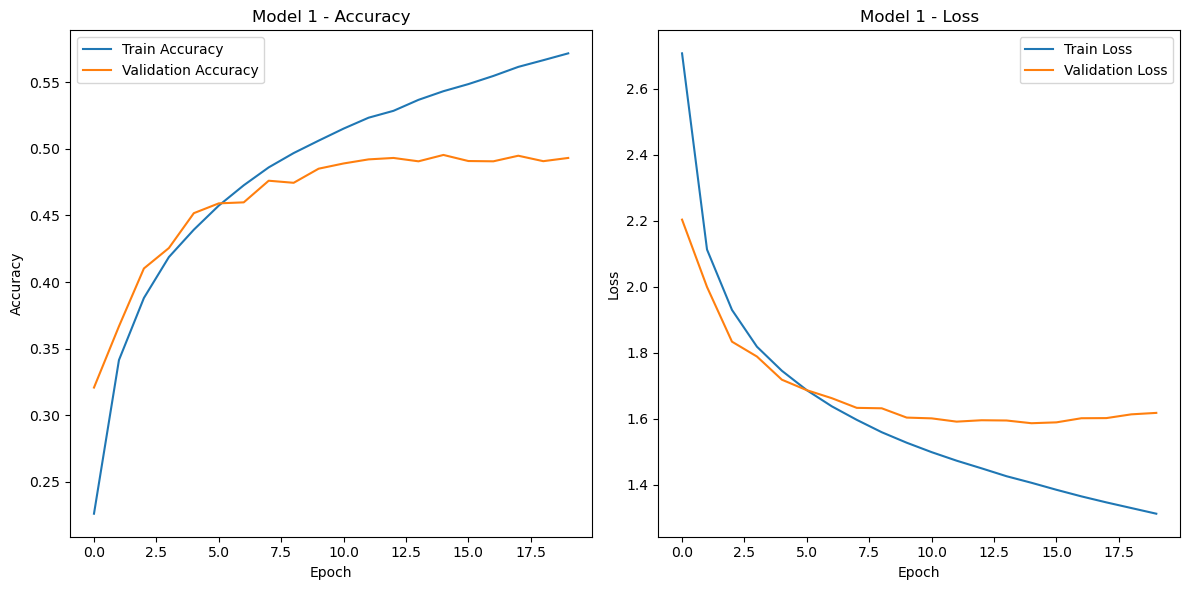


Evaluating Model 2...
Training Model 2...
Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 2.9836 - accuracy: 0.1798
******* Epoch: 1 ********
***** Starting sentence *****
>>.

poi l'addentar con piu` di cento ra
*****************************
***** Generated text *****
>>.

poi l'addentar con piu` di cento ra a e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e

73/73 [==============================] - 223s 3s/step - loss: 2.9836 - accuracy: 0.1798 - val_loss: 2.7641 - val_accuracy: 0.2068
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 2.5179 - accuracy: 0.2502
******* Epoch: 2 ********
***** Starting se

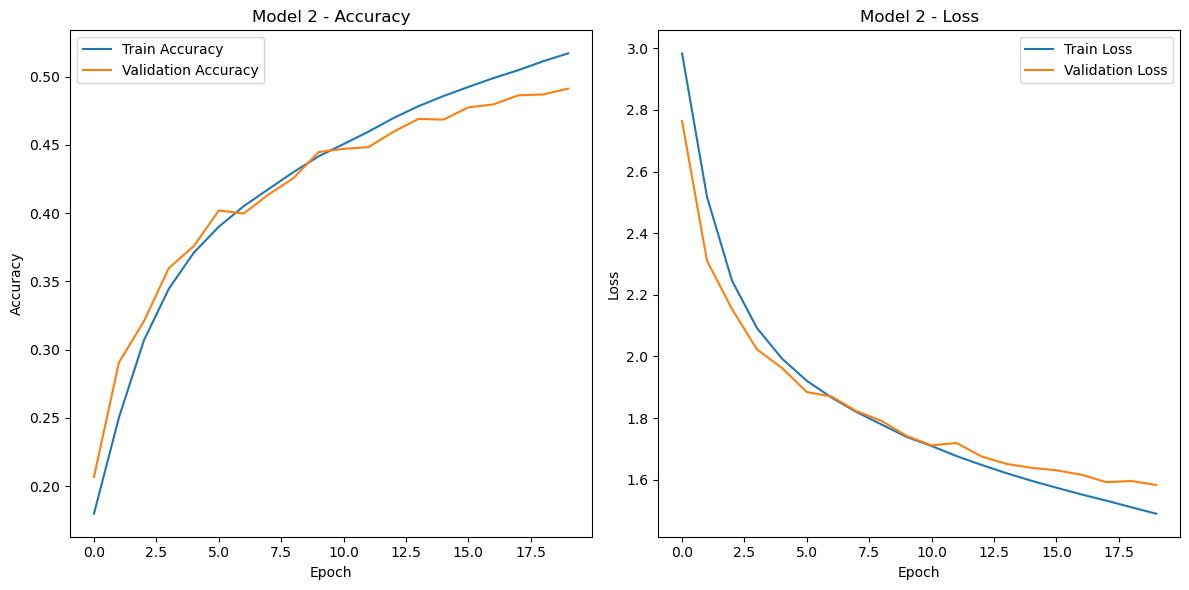


Evaluating Model 3...
Training Model 3...
Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 2.1290 - accuracy: 0.3423
******* Epoch: 1 ********
***** Starting sentence *****
 la testa di mio figlio fu, dal quale
  cominciar 
*****************************
***** Generated text *****
 la testa di mio figlio fu, dal quale
  cominciar che la sur sur sur sur sunta
  che la sur sur sur sur sur sur sura,
  che la sur sur sur sur sur sur sur sunta
  che la sur sur sur sur sur sur sura,
  che la sur sur sur sur sur sur sur sunta
  che la sur sur sur sur sur sur sura,
  che la sur sur sur sur sur sur sur sunta
  che la sur sur sur sur sur sur sura,
  che la sur sur sur sur sur sur sur sunta
  che la sur sur sur sur sur sur sura,
  ch

73/73 [==============================] - 653s 9s/step - loss: 2.1290 - accuracy: 0.3423 - val_loss: 2.0721 - val_accuracy: 0.3585
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 2.0634 - accuracy: 0.3584
******* Epoch: 2 ******

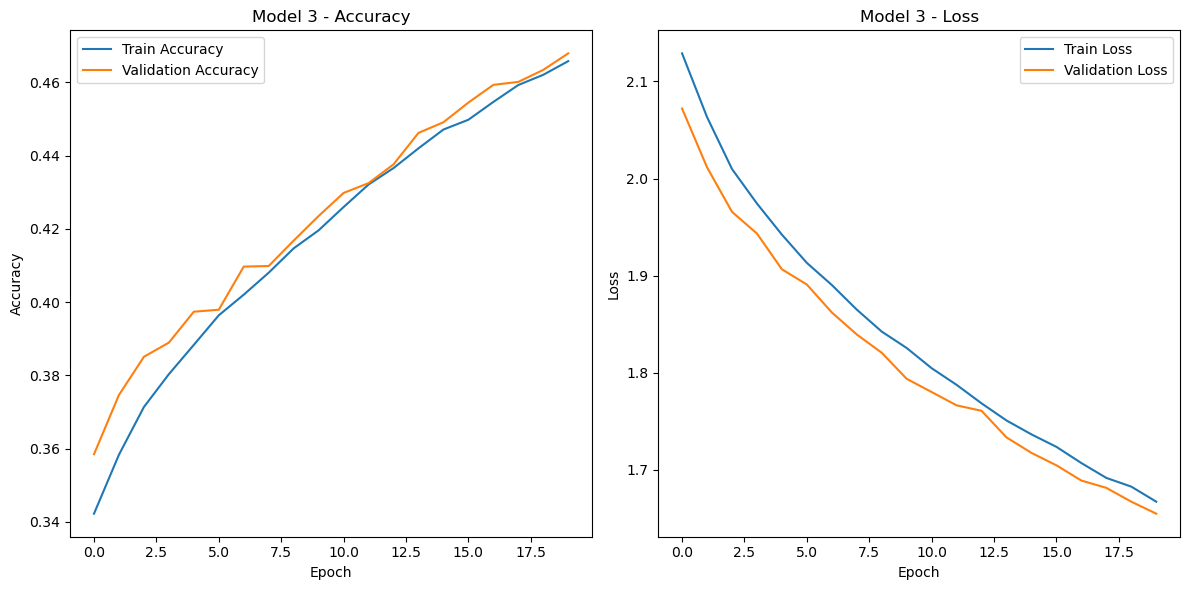

(1.6652802228927612, 0.4713279902935028)

In [51]:
## Train and Evaluate the Models

import matplotlib.pyplot as plt
from keras.callbacks import LambdaCallback
import sys

# Helper function to test text generation after each epoch
def testAfterEpoch(model, text, char_indices, indices_char, maxlen, epoch, _):
    print()
    print(f"******* Epoch: {epoch+1} ********")
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence

    print("***** Starting sentence *****")
    print(sentence)
    print("*****************************")

    for _ in range(400):  # Generate 400 characters
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = np.argmax(preds)
        next_char = indices_char[next_index]

        sentence = sentence[1:] + next_char
        generated += next_char

    print("***** Generated text *****")
    print(generated)
    print()

# Function to prepare data for a given chunk length
def prepare_data_for_chunk_length(text, chars, char_indices, maxlen, step=3):
    sentences = []
    next_chars = []
    for i in range(0, len(text) - maxlen, step):
        sentences.append(text[i: i + maxlen])
        next_chars.append(text[i + maxlen])
    x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
    y = np.zeros((len(sentences), len(chars)), dtype=bool)
    for i, sentence in enumerate(sentences):
        for t, char in enumerate(sentence):
            x[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1
    return x, y

# Function to train a model and evaluate its performance
def train_and_evaluate(model, x, y, text, char_indices, indices_char, maxlen, batch_size, epochs, model_name):
    # Split the data into training, validation, and test sets
    split_train = int(len(x) * 0.8)
    split_val = int(len(x) * 0.9)
    x_train, y_train = x[:split_train], y[:split_train]
    x_val, y_val = x[split_train:split_val], y[split_train:split_val]
    x_test, y_test = x[split_val:], y[split_val:]

    print(f"Training {model_name}...")
    print_callback = LambdaCallback(on_epoch_end=lambda epoch, _: testAfterEpoch(model, text, char_indices, indices_char, maxlen, epoch, _))
    
    # Train the model
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[print_callback],
        verbose=1
    )
    
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return test_loss, test_accuracy

# Train and evaluate each model
batch_size = 2048
epochs = 20

# Model 1 - Chunk length = 30
x_1, y_1 = prepare_data_for_chunk_length(text, chars, char_indices, maxlen=30)
print("Evaluating Model 1...")
train_and_evaluate(model_1, x_1, y_1, text, char_indices, indices_char, 30, batch_size, epochs, "Model 1")

# Model 2 - Chunk length = 50
x_2, y_2 = prepare_data_for_chunk_length(text, chars, char_indices, maxlen=40)
print("\nEvaluating Model 2...")
train_and_evaluate(model_2, x_2, y_2, text, char_indices, indices_char, 40, batch_size, epochs, "Model 2")

# Model 3 - Chunk length = 70
x_3, y_3 = prepare_data_for_chunk_length(text, chars, char_indices, maxlen=50)
print("\nEvaluating Model 3...")
train_and_evaluate(model_3, x_3, y_3, text, char_indices, indices_char, 50, batch_size, epochs, "Model 3")


In [30]:
import sys
def testAfterEpoch(epoch, _):
  print()
  print()
  print('******* Epoch: %d ********' % (epoch+1))
  start_index = random.randint(0, len(text)-maxlen-1)

  generated = ''
  sentence = text[start_index :  start_index + maxlen]
  generated = generated + sentence

  print('***** starting sentence *****')
  print(sentence)
  print('*****************************')
  sys.stdout.write(generated)

  for i in range(400):
    x_pred = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
      x_pred[0, t, char_indices[char]] = 1

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = np.argmax(preds)
    next_char = indices_char[next_index]

    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
  print()



In [31]:
print_callback = LambdaCallback(on_epoch_end=testAfterEpoch)

In [32]:
model.fit(x, y,
          batch_size = 2048,
          epochs = 20,
          callbacks = [print_callback])

Epoch 1/20
91/91 [==============================] - ETA: 0s - loss: 2.6218

******* Epoch: 1 ********
***** starting sentence *****
olui che tutto 'l mondo alluma
*****************************
olui che tutto 'l mondo alluma la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la 
91/91 [==============================] - 75s 806ms/step - loss: 2.6218
Epoch 2/20
91/91 [==============================] - ETA: 0s - loss: 2.0454

******* Epoch: 2 ********
***** starting sentence *****
e o lievemente o forte>>.

que
*****************************
e o lievemente o forte>>.

quen la per la ser con per la per la per la per la per la per la per la per la per la